In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def entropy(pmf, epsilon=1e-4):
    try:
        pmf = np.array(pmf)
        mask = pmf>epsilon
        pmf = pmf[mask]  # 0log0 = 0
        return -1.0 * np.dot(pmf, np.log2(pmf))
    except TypeError as te:
        print(pmf, "is not iterable")

# a = np.linspace(0, 1, 100)
# b = np.zeros(a.shape)
# for i, e in enumerate(a):
#     b[i] = entropy([e, 1-e])
# fig = plt.figure()
# plt.plot(a, b)
# plt.show()

def conditionalEntropy(cond_p, pmfs):
    assert len(cond_p) == len(pmfs)
    result = 0
    for i, p in enumerate(cond_p):
        result += p*entropy(pmfs[i, :])
    return result
    

def empiricalEntropy(label: pd.Series):
    pmf = label.value_counts().values / label.count()
    return entropy(pmf)

def empiricalConditionalEntropy(label: pd.Series, feature: pd.Series):
    assert label.count() == feature.count(), \
        "The length of label and feature should be the same when computing empirical conditional entropy"
    df = pd.DataFrame({'label':label, 'feature': feature})
    feature_values = feature.unique()  # get all distinct feature values
    result = 0
    for i, value in enumerate(feature_values):
        df_filtered = df.query('feature==@value')   # filter by feature value
        label_filtered = df_filtered['label']
        ee = empiricalEntropy(label_filtered)
        cond_p = feature.value_counts()[value]/feature.count()
        result += cond_p*ee
    return result

In [3]:
df = pd.read_csv('./test_data.csv', delimiter=',')
label = df['type']
empiricalEntropy(label)
empiricalConditionalEntropy(label=df['type'], feature=df['age'])
empiricalEntropy(label) - empiricalConditionalEntropy(label=df['type'], feature=df['work'])
empiricalEntropy(label) - empiricalConditionalEntropy(label=df['type'], feature=df['house'])
empiricalEntropy(label) - empiricalConditionalEntropy(label=df['type'], feature=df['credit'])

0.36298956253708536

In [21]:
data_path = '.\data\iris.data'
iris_raw_data = pd.read_csv(data_path, 
        names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], 
        delimiter=',')
iris_raw_data

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [36]:

iris_data = iris_raw_data.copy()
iris_data['class'], mapping_dict= iris_raw_data['class'].factorize()
iris_data.attrs =dict(zip(iris_data.columns.values, [False, False, False, False, False]))
iris_data.attrs

{'sepal length': False,
 'sepal width': False,
 'petal length': False,
 'petal width': False,
 'class': False}

In [63]:
class Kmeans1d():
    def __init__(self, epsilon=1e-2, max_step=20):
        self.stop_epsilon = epsilon
        self.MAX_STEP = max_step
    
    def fit(self, data: np.ndarray, k):
        assert len(data.shape) == 1, "The input data of Kmeans1d should be 1 dim"
        # initialization
        low_boundary = np.min(data)
        up_boundary = np.max(data)
        # randomly generate k points as initial center for each class
        center_points = low_boundary + (up_boundary-low_boundary)*np.random.rand(k)
        center_points = np.sort(center_points)
        center_points_last = np.ones(k)*np.inf
        record = pd.DataFrame({'data': data, 'cluster': np.zeros(data.shape)})
        
        cnt = 0
        while not self.stopping_condition(center_points, center_points_last) and cnt<self.MAX_STEP:
            cnt = cnt + 1
            center_points_last = center_points
            # step1: with fixed center points, cluster the samples
            for i, sample in enumerate(data):
                cluster_class = np.argmin(self.squaredEuclideanDistance(center_points, sample))
                record.iloc[i, 1] = np.int16(cluster_class)
            
            # step2: compute new center for each class
            for idx, center in enumerate(center_points_last):
                record_filtered = record.query("cluster==@idx")
                if record_filtered.empty:
                    new_center = center
                else:
                    new_center = record_filtered['data'].mean()
                center_points[idx] = new_center
        return center_points, record
    
    def stopping_condition(self, points, points_last):
        distance = self.squaredEuclideanDistance(points, points_last)
        if np.all(distance < self.stop_epsilon):
            return True 
        else:
            return False
    
    def auto_fit(self, data:np.ndarray, max_k=5, max_each=5):
        best_k = 0
        best_score = -np.inf
        best_cps = None # cps: center points
        best_rcd = None # rcd: record
        all_score = np.zeros(max_k-1)
        for i in np.arange(2, max_k+1):
            best_score_for_this_k = -np.inf
            best_rcd_for_this_k = None 
            best_cps_for_this_k = None
            for j in np.arange(2, max_each+1):
                # print(f"Trying k={i} for the {j}th time")
                cps, rcd = self.fit(data, k=i)
                score = self.silhouette(rcd)
                if score > best_score_for_this_k:
                    best_score_for_this_k = score
                    best_rcd_for_this_k = rcd
                    best_cps_for_this_k = cps
            all_score[i-2] = best_score_for_this_k
            if best_score_for_this_k > best_score:
                best_score = best_score_for_this_k
                best_cps = best_cps_for_this_k
                best_rcd = best_rcd_for_this_k
        
        return best_score, best_cps, best_rcd, all_score
        
    @staticmethod
    def squaredEuclideanDistance(x1, x2):
        return np.square(x1-x2)

    @staticmethod
    def silhouette(data:pd.DataFrame):
        clusters = np.sort(data['cluster'].unique())
        a = np.zeros(data['data'].count())
        b = np.zeros(data['data'].count())
        s = np.zeros(data['data'].count())
        for i, sample in enumerate(data.values):
            num = sample[0]
            cls = sample[1]
            
            # compute a(i)
            # a measure of how well i is assigned to its cluster 
            # (the smaller the value, the better the assignment).
            a_mask = np.int8(data['cluster'].values == cls)
            a_mask_sum = a_mask.sum()
            distance_to_all = Kmeans1d.squaredEuclideanDistance(num, data['data'].values)
            if a_mask_sum == 1:
                a[i] = 0
            elif a_mask_sum <= 0:
                raise ValueError("Cannot find sample with this class. Something wrong happened")
            else:
                a[i] = np.dot(distance_to_all, a_mask) / (a_mask_sum-1)
                
            # compute b(i)
            b_min = np.inf
            for c in clusters:
                if c == cls:
                    continue
                b_mask = np.int8(data['cluster'].values == c)
                assert b_mask.sum()>0, "Something wrong happened"
                temp_b = np.dot(distance_to_all, b_mask) / b_mask.sum()
                if temp_b < b_min:
                    b_min = temp_b
            b[i] = b_min
            
            if b[i] == np.inf:
                print(data)
                raise ValueError(f"WTF, b_min={b_min}")
            
            # compute s(i)
            if a_mask_sum > 1:
                try:
                    s[i] = 1.*(b[i]-a[i]) / np.max([a[i], b[i]])
                except RuntimeWarning:
                    print(f"Something wrong happened, a={a[i]}, b={b[i]}")
            else:
                s[i] = 0
            
        # Thus the mean s(i) over all data of the entire dataset is a measure of 
        # how appropriately the data have been clustered.
        return np.mean(s)
    
    @staticmethod
    def get_dividing_points(center_points):
        assert type(center_points) is np.ndarray
        cps = np.sort(center_points)
        dividing_points = (cps[:-1] + cps[1:]) / 2.0 
        dividing_points = np.insert(dividing_points, 
                                    [0, dividing_points.size], 
                                    [-np.inf, np.inf], 
                                    axis=0)
        return dividing_points

kk = Kmeans1d()
# cps, rcd = kk.fit(iris_data['petal length'].values, k=5)
best_score, best_cps, best_rcd, all_score = \
                kk.auto_fit(iris_data['petal width'].values, max_k=5, max_each=8)
print(best_score)
print(best_cps)
print(all_score)

0.8587587025457097
[0.244      1.32307692 2.05833333]
[0.83384214 0.8587587  0.74498711 0.72661841]


In [64]:
def preprocess(data:pd.DataFrame, max_k=5, max_each=8):
    cols = data.columns.values[:-1] # except the last one
    dividing_points_dict = {}
    kmeans = Kmeans1d()
    for col in cols:
        # discrete = self.check_discrete(data, col)
        discrete = False
        if not discrete:
            # apply kmeans to continuous data
            best_score, best_cps, best_rcd, all_score = \
                kmeans.auto_fit(data[col].values, max_k=max_k, max_each=max_each)
            dividing_points = kmeans.get_dividing_points(best_cps)
            dividing_points_dict[col] = dividing_points
            print(f"Attribute {col} has been discretized")
    return dividing_points_dict

dividing_points_dict = preprocess(iris_data)
dividing_points_dict

Attribute sepal length has been discretized
Attribute sepal width has been discretized
Attribute petal length has been discretized
Attribute petal width has been discretized


{'sepal length': array([      -inf, 5.97344815,        inf]),
 'sepal width': array([      -inf, 2.61780428, 3.07032844, 3.55895692,        inf]),
 'petal length': array([      -inf, 3.31110048,        inf]),
 'petal width': array([      -inf, 0.79051852, 1.70547504,        inf])}

In [58]:
iris_data['sepal length'].values

array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
       4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
       5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
       5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
       6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
       6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
       6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
       6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3,
       6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5,
       7.7, 7.7, 6. , 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2,
       7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6. , 6.9, 6.7, 6.9, 5.8,
       6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9])

In [65]:
np.digitize(iris_data['sepal length'].values, dividing_points_dict['sepal length'])-1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [85]:
class Node():
    def __init__(self, label=None, parent=None, children=None):
        self.parent = parent
        self.children = children
        self.label = label  
        self.leaf_label = None
        self.test_cond = None   # test condition of each internal node is here
                                # list of str (used in pd.DataFrame.query)
    
    def __str__(self, level=0):
        if not self.children:
            ret = "\t"*level + repr(self.leaf_label) + "\n"
        else:
            ret = "\t"*level + repr(self.label) + "\n"
        if self.children:
            for child in self.children:
                ret += child.__str__(level+1)
        return ret
    
    def mermaid(self):
        ss = self.gen_mermaid()
        ss = 'graph LR\nroot' + ss
        return ss
    
    def gen_mermaid(self, prefix='a'):
        if not self.children:
            ret = "--" + self.label + "-->" + prefix + "(" + self.leaf_label + ")\n"
        else:
            cond = " ".join(re.findall("[a-zA-Z]+", self.test_cond[0]))
            ret = "--" + self.label + "-->" + prefix + "(" + cond + ")\n" 
        if self.children:
            for j, child in enumerate(self.children):
                ret += prefix + "("+cond+")"
                ret += child.gen_mermaid(prefix+str(j))
        return ret
    
    
class DecisionTree():
    def __init__(self, train_data: pd.DataFrame, 
                    mapping_dict = None,
                    stop_threshold=1e-2):
        self.stop_threshold = stop_threshold
        self.mapping_dict = mapping_dict
        # pd.DataFrame.attrs should contain whether each column is discrete or not
        for c in train_data.columns.values:
            if c not in train_data.attrs.keys():
                raise ValueError("Input data (pd.DataFrame) should contain whether each column is discrete or not")
        # discretize the columns with continuous data
        self.dividing_points_dict = self.preprocess(train_data)
        
        self.root = self.grow(train_data)
        self.root.label = 'root'

    def grow(self, data:pd.DataFrame):
        if self.stopping_condition(data):
            # finnally we reach the leaf
            leaf = Node()
            leaf.leaf_label = self.classify(data)
            leaf.leaf_label = self.mapping_dict[leaf.leaf_label]
            return leaf
        else:
            root = Node(label=None, children=list())
            root.test_cond, attr = self.find_best_split(data)
            for lb in root.test_cond:
                assert type(lb) is str
                sub_data = data.query(lb)
                if sub_data.empty:
                    continue
                sub_data = sub_data.drop(columns=[attr])  # this attribute has been used this time
                child = self.grow(sub_data)
                child.parent = root
                child.label = lb
                root.children.append(child)
        return root

    def check_discrete(self, data: pd.DataFrame, col: str):
        return data.attrs[col]

    def stopping_condition(self, data:pd.DataFrame):
        assert len(data.columns.values) > 0, "Cannot find the label column"
        if len(data.columns.values) == 1:   # the last one column is the label of each sample
            # all attributes have been used, thus stop
            return True
        if data.iloc[:,-1].nunique() == 1:
            return True
        max_info_gain, _, _ = self.find_largest_info_gain(data)
        # print(max_info_gain)
        if max_info_gain < self.stop_threshold:
            return True
        
        return False

    def find_best_split(self, data:pd.DataFrame):
        # select the attribute with largest information gain
        _, attr_with_max_info_gain, attr_discrete = self.find_largest_info_gain(data)
        if attr_discrete:
            # for example, if available values for attr 'A' is [0, 1 ,2], then cond = ['A==0', 'A==1', 'A==2']
            cond = [attr_with_max_info_gain+'=='+str(i) for i in data[attr_with_max_info_gain].unique()]
        else:
            # raise ValueError("Continuous data is not available now")
            dividing_points = self.dividing_points_dict[attr_with_max_info_gain]
            cond = []
            for i in range(len(dividing_points)-1):
                if dividing_points[i] == -np.inf:
                    ss = attr_with_max_info_gain + "<= %.4f"%dividing_points[i+1]
                    cond.append(ss)
                elif dividing_points[i+1] == np.inf:
                    ss = attr_with_max_info_gain + "> %.4f"%dividing_points[i]
                    cond.append(ss)
                else:
                    ss = "%.4f < "%dividing_points[i] +  attr_with_max_info_gain + "<= %.4f"%dividing_points[i+1]

        return cond, attr_with_max_info_gain
    
    def find_largest_info_gain(self, data:pd.DataFrame):
        """ select the attribute with largest information gain

        Args:
            data (pd.DataFrame): data with label in the last column

        Returns:
            float: attr_with_max_info_gain, max_info_gain, attr_discrete
        """
        max_info_gain = -np.inf
        for col in data.columns.values[:-1]: # the last column is the label, thus ignore it
            discrete = self.check_discrete(data, col)
            if discrete:
                info_gain = empiricalEntropy(data.iloc[:, -1]) - \
                            empiricalConditionalEntropy(label=data.iloc[:, -1], feature=data[col])
            else:
                col_feature = np.digitize(data[col].values, self.dividing_points_dict[col])-1
                col_feature = pd.Series(col_feature)
                info_gain = empiricalEntropy(data.iloc[:, -1]) - \
                            empiricalConditionalEntropy(label=data.iloc[:, -1], feature=col_feature)
                
            # get largest info gain
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                attr_with_max_info_gain = col
                attr_discrete = discrete
        return max_info_gain, attr_with_max_info_gain, attr_discrete
        
    
    def classify(self, data:pd.DataFrame):
        return data.iloc[:,-1].mode().values[0]
    
    
    def preprocess(self, data:pd.DataFrame, max_k=5, max_each=8):
        cols = data.columns.values[:-1] # except the last one
        dividing_points_dict = {}
        kmeans = Kmeans1d()
        for col in cols:
            discrete = self.check_discrete(data, col)
            if not discrete:
                # apply kmeans to continuous data
                best_score, best_cps, best_rcd, all_score = \
                    kmeans.auto_fit(data[col].values, max_k=max_k, max_each=max_each)
                dividing_points = kmeans.get_dividing_points(best_cps)
                dividing_points_dict[col] = dividing_points
                print(f"Attribute {col} has been discretized")
        return dividing_points_dict
            
# # test discrete
# dataframe = pd.read_csv('./test_data.csv', delimiter=',')
# dataframe.attrs =dict(zip(dataframe.columns.values, [True, True, True, True, True]))
# tree = DecisionTree(dataframe)
# print(tree.root.mermaid())

data_path = '.\data\iris.data'
iris_raw_data = pd.read_csv(data_path, 
        names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'], 
        delimiter=',')
iris_data = iris_raw_data.copy()
iris_data['class'], mapping_dict= iris_raw_data['class'].factorize()
iris_data.attrs =dict(zip(iris_data.columns.values, [False, False, False, False, False]))
tree = DecisionTree(iris_data, mapping_dict)
print(tree.root.mermaid())

Attribute sepal_length has been discretized
Attribute sepal_width has been discretized
Attribute petal_length has been discretized
Attribute petal_width has been discretized
graph LR
root--root-->a(petal width)
a(petal width)--petal_width<= 0.9600-->a0(Iris-setosa)
a(petal width)--petal_width> 0.9600-->a1(sepal length)
a1(sepal length)--sepal_length<= 5.8251-->a10(sepal width)
a10(sepal width)--sepal_width<= 3.2179-->a100(petal length)
a100(petal length)--petal_length<= 3.1850-->a1000(Iris-versicolor)
a100(petal length)--petal_length> 3.1850-->a1001(Iris-versicolor)
a1(sepal length)--sepal_length> 5.8251-->a11(sepal width)
a11(sepal width)--sepal_width<= 3.2179-->a110(petal length)
a110(petal length)--petal_length> 3.1850-->a1100(Iris-virginica)
a11(sepal width)--sepal_width> 3.2179-->a111(petal length)
a111(petal length)--petal_length> 3.1850-->a1110(Iris-virginica)



In [78]:
import re
st = "petal_length<= 3.2097"
" ".join(re.findall("[a-zA-Z]+", st))

'petal length'

   1. sepal length in cm
   2. sepal width in cm
   3. petal length in cm
   4. petal width in cm
   5. class: 

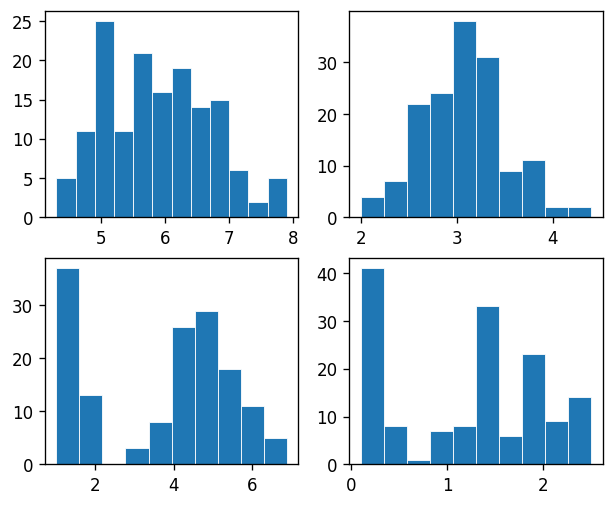

In [390]:
fig, axs = plt.subplots(2,2, figsize=(6, 5), dpi=120)
bins = [12,10,10,10]
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        ax.hist(iris_data.iloc[:, i*2+j].values, bins=bins[i*2+j], linewidth=0.5, edgecolor="white")
plt.show()


In [382]:
kk.get_dividing_points(best_cps)

array([0.493247, 1.209247])

In [341]:
# record.groupby(['cluster']).min()

,data
cluster,
0.0,0.1
1.0,1.0
2.0,1.8


The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

Reference: 

[Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))


In [384]:
a = 1.235466312
s = "%.2f" % a
print(s)

1.24
